In [1]:
import Data.dataset as ds
import Plots.plots as pl
import Calculations.monte_carlo as mc
import Calculations.calculations as cal

# Monte Carlo Simulation 1'000'000 Jahre

In [2]:
zone1 = ds.get_out1()
zone2 = ds.get_out2()

mass = ('Mass', 'Mass [kg]')
velocity = ('Velocity', 'Velocity [m/s]')
kinetic_energy = ('Kinetic Energy', 'Kinetic Energy [kJ]')
timedelta = ('Timedelta', 'TimeDiffHours')
n_years = 1000000

## Ersetze Ausreisser mit Median

In [3]:
without_outliers_zone1 = ds.replace_outliers_with_median(zone1)
without_outliers_zone2 = ds.replace_outliers_with_median(zone2)

## Simulationsdaten Zeitabstände erstellen
Die Zeitabstände werden solange erstellt, bis die kumulative Stundenzahl 1'000'000 Jahre entspricht.
Diese wurden mit der Gamma Verteilung simuliert. 

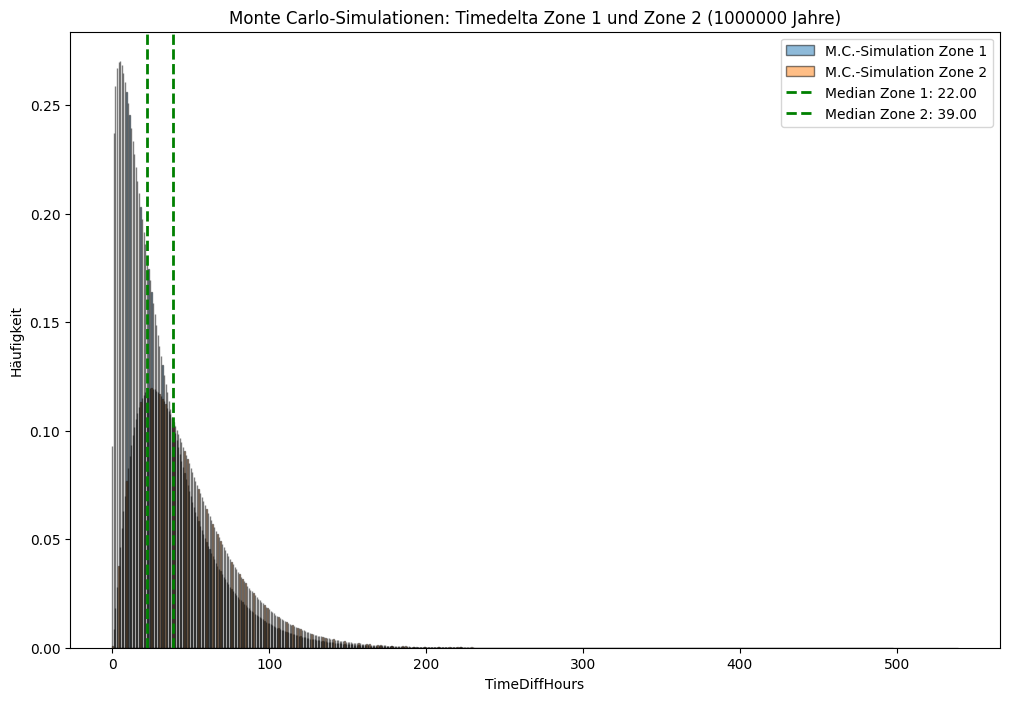

In [4]:
sim_timediff_zone1 = mc.simulate_gamma_distribution_timediff(without_outliers_zone1, n_years, timedelta)
sim_timediff_zone2 = mc.simulate_gamma_distribution_timediff(without_outliers_zone2, n_years, timedelta)

n_simulations_zone1 = len(sim_timediff_zone1)
n_simulations_zone2 = len(sim_timediff_zone2)

pl.show_simulated_data(sim_timediff_zone1, sim_timediff_zone2, timedelta, n_years)

## Simulationsdaten Geschwindigkeit erstellen
Anhand der Gesamtanzahl simulierten Daten für Zeitabstände, wurden Geschwindigkeiten simuliert.
Diese wurden mit der Normal Verteilung simuliert.

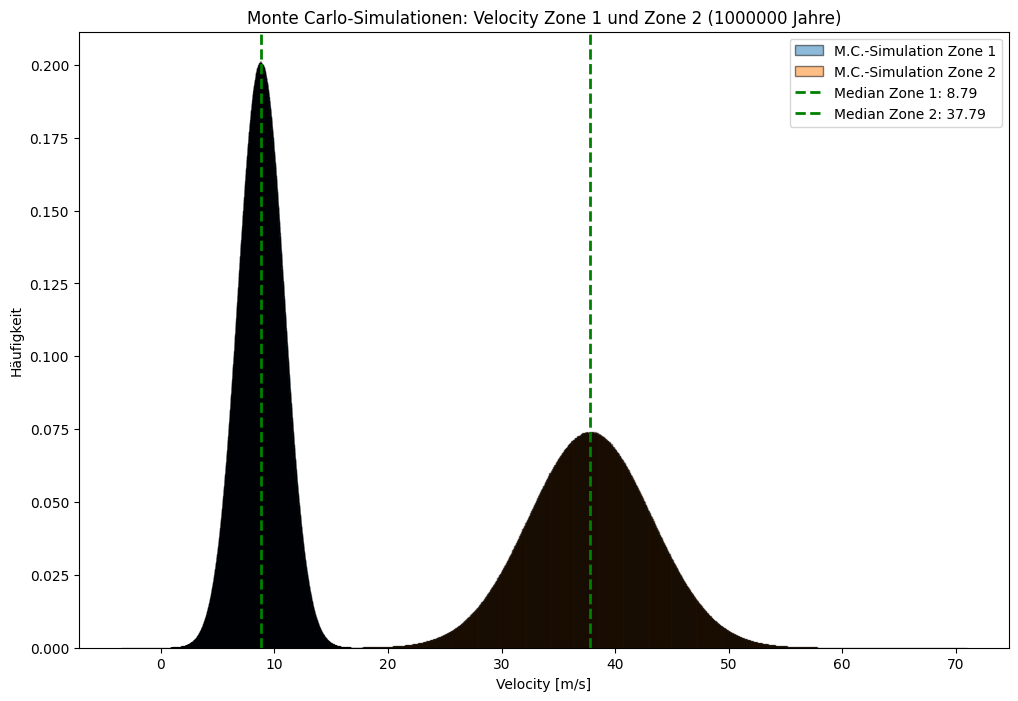

In [5]:
sim_velocity_zone1 = mc.simulate_norm_distribution(without_outliers_zone1, n_simulations_zone1, velocity)
sim_velocity_zone2 = mc.simulate_norm_distribution(without_outliers_zone2, n_simulations_zone2, velocity)

pl.show_simulated_data(sim_velocity_zone1, sim_velocity_zone2, velocity, n_years)

## Simulationsdaten Masse erstellen
Anhand der Gesamtanzahl simulierten Daten für Zeitabstände, wurden Massen simuliert.
Diese wurden mit der Normal Verteilung simuliert.

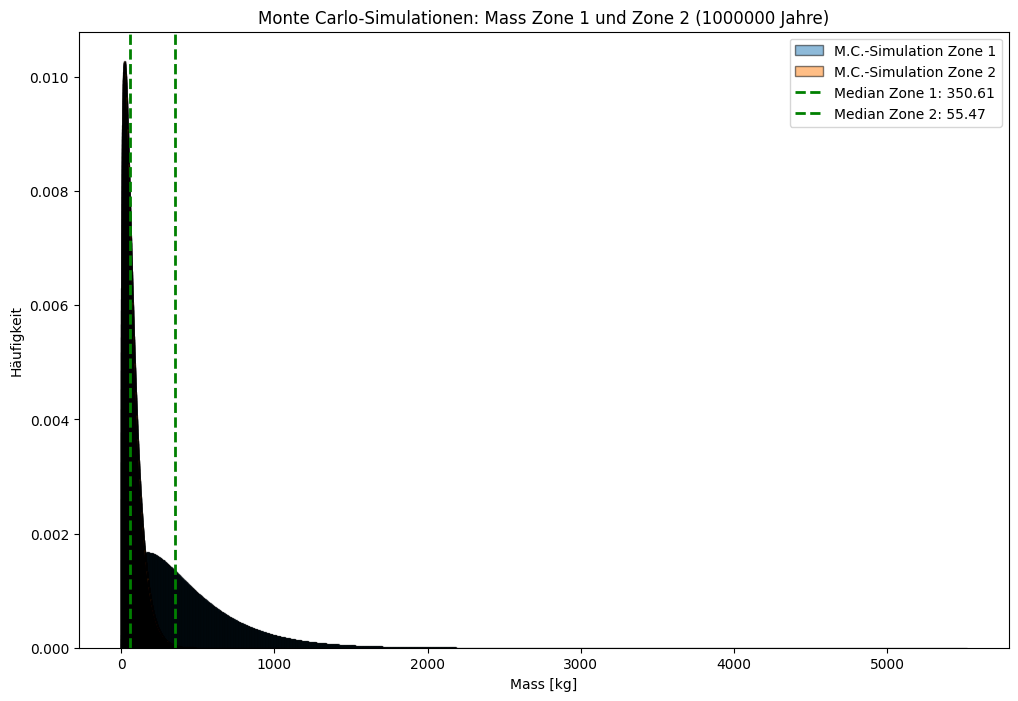

In [6]:
sim_mass_zone1 = mc.simulate_gamma_distribution(without_outliers_zone1, n_simulations_zone1, mass)
sim_mass_zone2 = mc.simulate_gamma_distribution(without_outliers_zone2, n_simulations_zone2, mass)

pl.show_simulated_data(sim_mass_zone1, sim_mass_zone2, mass,n_years)

## Verarbeitung Simulationsdaten
### 1. Kinetische Energie berechnen
Mit den simulierten Daten Geschwindigkeit und Masse, kann die Kinetische Energie (kJ) berechnet werden.
Formel: Kinetische Energie = (0.5 * Masse * Geschwindigkeit^2) / 1000

### 2. Datum und Uhrzeit ermitteln
Anhand den Zeitabständen, kann man Datum und Uhrzeit von allen Erreignissen festlegen.

In [7]:
merged_zone1 = ds.merge_simulated_data(sim_mass_zone1, sim_velocity_zone1, sim_timediff_zone1)

In [8]:
merged_zone2 = ds.merge_simulated_data(sim_mass_zone2, sim_velocity_zone2, sim_timediff_zone2)

### 3. Kumulatives Gewicht im Netz ermitteln
Um dies zu berechnen werden die Simulationsdaten von beiden Zonen zusammengenommen, weil beide Zonen auf das gleiche Netz einwirken.
Das Gewicht im Netz wird kumulativ berechnet und jeden Tag um 23:30Uhr werden alle Steine im Netz entfernt.

In [9]:
sim_rocks_in_net = cal.sim_calculate_cumulative_mass_since_clearing(merged_zone1, merged_zone2)

## Netzbruchwahrscheinlichkeit berechnen
Die Formel zur Netzbruchwahrscheinlichkeit wird mit folgender Grafik hergeleitet:
Belastungsfähigkeit(kJ) = -0.25 * Last(kg) + 1000

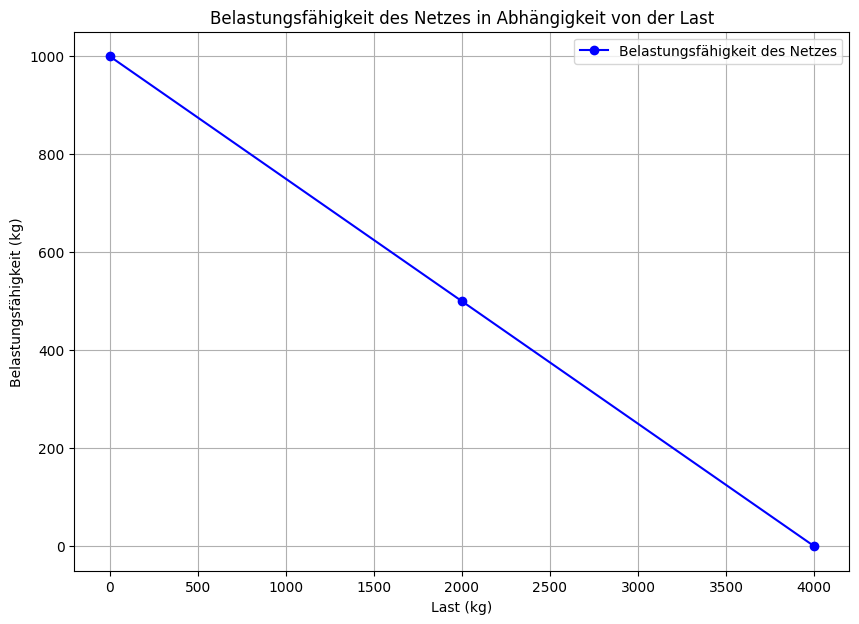

In [2]:
pl.show_linear_net_resistence()

In [10]:
count = (sim_rocks_in_net['Kinetic Energy [kJ]'] >= ((-0.25*sim_rocks_in_net['CumulativeMassInNet'])+1000)).sum()
print(count, 'Netzbrüche')
net_brake_probability = count / len(sim_rocks_in_net)
print(net_brake_probability*100, '% Netzbruchwahrscheinlichkeit')

11351 Netzbrüche
0.002359187823933806 % Netzbruchwahrscheinlichkeit


## Gesamttodeswahrscheinlichkeit berechnen
Mittels der Berechnung der Todeswahrscheinlichkeit von «Direkter/Indirekter Treffer» kann die Gesamttodeswahrscheinlichkeit berechnet werden.
Gesamttodeswahrscheinlichkeit = (direkter + indirekter Treffer) * 1.6 Personen/Fahrzeug * Netzbruchwahrscheinlichkeit

In [11]:
traffic_volume = 1200 #Anzahl Fahrzeuge/Tag
vehicle_length = 4.4  #Meter
vehicle_velocity = 60 #km/h
lethality = 0.1       #Letalität bei 60 km/h
reaction_time = 1     #Sekunden

#Berechnung Todeswahrscheinlichkeit direkter Treffer
t_pass_direct_hit = vehicle_length / (vehicle_velocity / 3.6)
transit_time_direct_hit = traffic_volume * t_pass_direct_hit
direct_hit = (transit_time_direct_hit / 86400) 

#Berechnung Todeswahrscheinlichkeit indirekter Treffer
vehicle_velocity_ms = vehicle_velocity * 0.277778
reaction_distance = vehicle_velocity_ms * reaction_time
break_distance = (vehicle_velocity / 10) ** 2
combined_distance = reaction_distance + break_distance

t_pass_indirect_hit = combined_distance / vehicle_velocity_ms
transit_time_indirect_hit = traffic_volume * t_pass_indirect_hit * lethality
indirect_hit = (transit_time_indirect_hit / 86400) 

overall_death_probability = (direct_hit + indirect_hit) * 1.6 * net_brake_probability
print(overall_death_probability*100, '% Gesamttodeswahrscheinlichkeit')

3.0407300671428397e-05 % Gesamttodeswahrscheinlichkeit
